In [198]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os

In [199]:
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
SEQ_LENGTH = 24
DATA_DIR = './data/processed' 

FEATURES = ['Temperatura powietrza (oficjalna)', 'Kierunek wiatru (czujnik)', 'Średnia prędkość wiatru czujnik 10 minut']
TARGET = 'Temperatura powietrza (oficjalna)'

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# PREPARE DATE

In [200]:
paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            paths.append(full_path)
            print("Found file:", full_path)
            
df = pd.DataFrame()
for path in tqdm(paths):
    temp_df = pd.read_csv(path)
    df = pd.concat([df, temp_df], ignore_index=True)

Found file: ./data/processed/meteo_wroclaw_2012.csv
Found file: ./data/processed/meteo_wroclaw_2025.csv
Found file: ./data/processed/meteo_wroclaw_2022.csv
Found file: ./data/processed/meteo_wroclaw_2014.csv
Found file: ./data/processed/meteo_wroclaw_2016.csv
Found file: ./data/processed/meteo_wroclaw_2015.csv
Found file: ./data/processed/meteo_wroclaw_2023.csv
Found file: ./data/processed/meteo_wroclaw_2021.csv
Found file: ./data/processed/meteo_wroclaw_2013.csv
Found file: ./data/processed/meteo_wroclaw_2020.csv
Found file: ./data/processed/meteo_wroclaw_2018.csv
Found file: ./data/processed/meteo_wroclaw_2010.csv
Found file: ./data/processed/meteo_wroclaw_2019.csv
Found file: ./data/processed/meteo_wroclaw_2024.csv
Found file: ./data/processed/meteo_wroclaw_2017.csv


100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


In [201]:
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+--------------+---------------------+-----------------------------+-------------------------------------+--------------------------------+-----------------------+--------------------------+----------------------------+--------------------------------------------+---------------------------------+-----------------------------------------------------------+-------------------------------------------+------------------------------------+
|    |   Station ID | Datetime            |   Kierunek wiatru (czujnik) |   Temperatura powietrza (oficjalna) |   Temperatura gruntu (czujnik) |   Suma opadu dobowego |   Suma opadu godzinowego |   Suma opadu 10 minutowego |   Średnia prędkość wiatru czujnik 10 minut |   Prędkość maksymalna (czujnik) |   Największy poryw w okresie 10min ze stacji Synoptycznej |   Wilgotność względna powietrza (czujnik) |   Zapas wody w śniegu (obserwator) |
|----+--------------+---------------------+-----------------------------+-------------------------------------

In [202]:
nan_counts = df.isna().sum()
print("NaN counts per column:")
print(tabulate(nan_counts.reset_index().rename(columns={'index': 'Column', 0: 'NaN Count'}), headers='keys', tablefmt='psql'))

NaN counts per column:
+----+---------------------------------------------------------+-------------+
|    | Column                                                  |   NaN Count |
|----+---------------------------------------------------------+-------------|
|  0 | Station ID                                              |           0 |
|  1 | Datetime                                                |           0 |
|  2 | Kierunek wiatru (czujnik)                               |        8424 |
|  3 | Temperatura powietrza (oficjalna)                       |      578492 |
|  4 | Temperatura gruntu (czujnik)                            |      580343 |
|  5 | Suma opadu dobowego                                     |      707044 |
|  6 | Suma opadu godzinowego                                  |      646521 |
|  7 | Suma opadu 10 minutowego                                |      491664 |
|  8 | Średnia prędkość wiatru czujnik 10 minut                |      569497 |
|  9 | Prędkość maksymalna (c

In [203]:
df = df[df['Datetime'] > '2012-01-01']

df.dropna(subset=FEATURES + [TARGET], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Dataframe shape after filtering:", df.shape)

Dataframe shape after filtering: (73163, 13)


In [204]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
print(df['Datetime'].dtype)
df = df.sort_values('Datetime').reset_index(drop=True)
df['Timespan'] = df['Datetime'].diff().dt.total_seconds() / 60


median_span = df['Timespan'].median()
df['Is_irregular'] = df['Timespan'] > median_span * 1.5
print("Median Timespan:", median_span)
print("Irregular intervals found:", df['Is_irregular'].sum())

datetime64[ns]
Median Timespan: 10.0
Irregular intervals found: 7121


In [205]:
print("Dataframe shape after dropping NaNs:", df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

Dataframe shape after dropping NaNs: (73163, 15)
+----+--------------+---------------------+-----------------------------+-------------------------------------+--------------------------------+-----------------------+--------------------------+----------------------------+--------------------------------------------+---------------------------------+-----------------------------------------------------------+-------------------------------------------+------------------------------------+------------+----------------+
|    |   Station ID | Datetime            |   Kierunek wiatru (czujnik) |   Temperatura powietrza (oficjalna) |   Temperatura gruntu (czujnik) |   Suma opadu dobowego |   Suma opadu godzinowego |   Suma opadu 10 minutowego |   Średnia prędkość wiatru czujnik 10 minut |   Prędkość maksymalna (czujnik) |   Największy poryw w okresie 10min ze stacji Synoptycznej |   Wilgotność względna powietrza (czujnik) |   Zapas wody w śniegu (obserwator) |   Timespan | Is_irregular   |
|

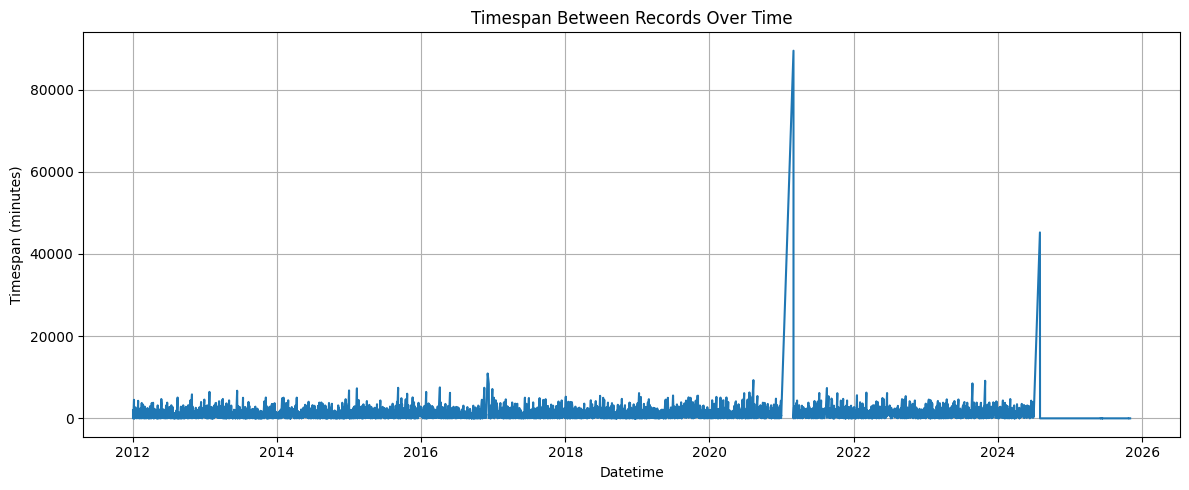

In [206]:
plt.figure(figsize=(12, 5))
plt.plot(df['Datetime'], df['Timespan'])
plt.title('Timespan Between Records Over Time')
plt.xlabel('Datetime')
plt.ylabel('Timespan (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def create_sequences(data, seq_length, features, target):
    sequences = []
    targets = []
    for i in tqdm(range(len(data) - seq_length)):
        seq = data[features].iloc[i:i+seq_length].values
        tgt = data[target].iloc[i+seq_length]
        sequences.append(seq)
        targets.append(tgt)
    return np.array(sequences), np.array(targets)
sequences, targets = create_sequences(df, SEQ_LENGTH, FEATURES, TARGET)
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)

split_index = int(len(sequences) * (1 - TEST_SIZE))
X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = targets[:split_index], targets[split_index:]
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
